# Exploración de datos para series temporales

In [56]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import periodogram
from scipy import fftpack

Monterrey = pd.read_csv("Files/Datos_2022_2023_CENTRO_limpios.csv", parse_dates=[0], index_col = "date")
daily_Monterrey = Monterrey.resample('D').mean()
daily_Monterrey

,CO,NO,NO2,NOX,O3,PM10,PM2.5,PRS,RAINF,RH,SO2,SR,TOUT,WSR,WDR
date,,,,,,,,,,,,,,,
2022-01-01,1.532500,5.152917,18.902500,24.255833,25.416667,68.583333,29.173750,705.870833,0.0,24.791667,4.329167,0.146958,26.112917,5.733333,185.291667
2022-01-02,1.230000,3.760833,12.312500,16.241667,26.654167,84.875000,11.750000,716.475000,0.0,25.083333,5.183333,0.144375,14.480417,9.766667,80.166667
2022-01-03,1.197500,5.137500,12.600000,17.987500,31.666667,41.916667,7.232083,720.066667,0.0,24.958333,3.546250,0.145375,9.794583,9.208333,77.500000
2022-01-04,1.743333,20.233333,37.887500,58.308333,18.375000,76.000000,30.655417,714.470833,0.0,30.416667,5.975000,0.139417,12.896667,4.737500,171.333333
2022-01-05,1.656250,15.480000,36.303750,51.986667,25.095833,88.120833,27.819458,710.172083,0.0,24.270833,7.105000,0.149083,19.871875,6.280000,167.629167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-13,0.414167,3.658333,6.512500,10.387500,29.375000,45.041667,12.966667,710.433333,0.0,43.125000,2.087500,0.288542,31.052083,11.570833,64.708333
2023-08-14,0.462083,4.733333,6.866667,11.816667,25.541667,49.208333,13.393333,711.454167,0.0,50.541667,1.983333,0.228000,30.116250,11.745833,81.166667
2023-08-15,0.496667,5.404167,8.300000,13.945833,24.500000,47.833333,13.322500,712.833333,0.0,49.000000,2.200000,0.252042,29.815417,10.370833,72.416667


## Funciones 

In [64]:
def graficar_serie_tiempo(df, contaminante):
    fig = go.Figure()

    fig.add_trace(go.Scatter(x=df.index, y=df, name=f'{contaminante}'))
        
    fig.update_xaxes(
        rangeslider_visible=True,
        rangeselector=dict(
            buttons=list([
                dict(count=7, label="1w", step="day", stepmode="backward"),
                dict(count=1, label="1m", step="month", stepmode="backward"),
                dict(step="all")
            ])
        )
    )

    fig.show()

def Periodograma(ts, detrend='linear', window='boxcar', scaling='density', ts_frequency=None, show_minor_ticks=True, axsize=(12, 3)): 
    """
    Take timeseris and plot the periodogram(s).
    If data has multiple columns, one plot is made
    for each column.
    The time period format (df.index.to_period()) is
    preferred for clarity, but any format will work.

    Parameters
    ----------
    ts : DataFrame or Series with data to visualize
    detrend : whether and how to detrend the data
    window : the shape of the time window
    scaling : return either power spectral density
              or power spectrum
    ts_frequency : override timeseries index frequency
                   (for display only, in the xlabel)
    show_minor_ticks : plot minor ticks
    axsize : the size of a single plot in the figure

    Returns
    -------
    list_periods_spectra: List of tuples (periods, spectrum) for each time series
    """

    list_periods_spectra = []
    if not isinstance(ts, pd.Series) and not isinstance(ts, pd.DataFrame):
        raise Exception(f'data must be pd.Series or pd.DataFrame')
    if isinstance(ts, pd.Series):
        ts = pd.DataFrame(ts)

    num_cols = len(ts.columns.to_list())
    fig, ax = plt.subplots(num_cols, 1, figsize=(axsize[0], num_cols * axsize[1]), layout='constrained')
    if num_cols == 1:
        ax = np.array([ax])
    for i in range(num_cols):
        c = ts.columns.to_list()[i]
        frequencies, spectrum = periodogram(
            ts[c],
            fs=1,
            detrend=detrend,
            window=window,
            scaling=scaling,
        )
        with np.errstate(divide='ignore'):
            periods = 1 / frequencies
            list_periods_spectra.append((periods, spectrum))
        ax[i].step(periods, spectrum, color="purple")
        ax[i].set_xscale("log")
        ax[i].xaxis.set_major_formatter('{x:.0f}')
        if show_minor_ticks:
            ax[i].xaxis.set_minor_formatter('{x:.0f}')
            ax[i].grid(visible=True, which='both', axis='both')
        else:
            ax[i].grid(visible=True, which='major', axis='both')
        xlabel = f'Periodo (Días)'
        if ts_frequency is not None:
            xlabel += f', freqstr: {ts_frequency}'
        else:
            if hasattr(ts.index, 'freqstr'):
                xlabel += f', freqstr: {ts.index.freqstr}'
        ax[i].set_xlabel(xlabel)
        if scaling == 'density':
            ax[i].set_ylabel("power spectral density")
        else:
            ax[i].set_ylabel("power spectrum")
        ax[i].set_title(c)
    fig.suptitle('Periodogram')
    fig.show()
    return list_periods_spectra

def Top_10_Periodogram(df, list_periods_spectra):

    # Nombres de las columnas (DataFrame)
    columns = df.columns

    for i, (periods, spectrum) in enumerate(list_periods_spectra):
        # Ordenar espectros en orden descendente y tomar los top 10
        top_indices = np.argsort(spectrum)[-10:][::-1]
        top_periods = periods[top_indices]
        top_spectra = spectrum[top_indices]
        
        # Crear DataFrame para la serie actual
        df = pd.DataFrame({
            "top_periods": top_periods,
            "top_spectra": top_spectra
        }).sort_values(by="top_spectra", ascending=False)
        
        print(f"\nTop 10 para la variable '{columns[i]}':")
        display(df)

## PM 10

In [57]:
Monterrey_PM10 = daily_Monterrey[["PM10", "PRS", "RAINF", "RH", "SO2", "SR", "TOUT", "WSR", "WDR"]]

In [61]:
graficar_serie_tiempo(Monterrey_PM10["PM10"], "PM10")

C:\Users\José Antonio\AppData\Local\Temp\ipykernel_2472\4236003845.py:87: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



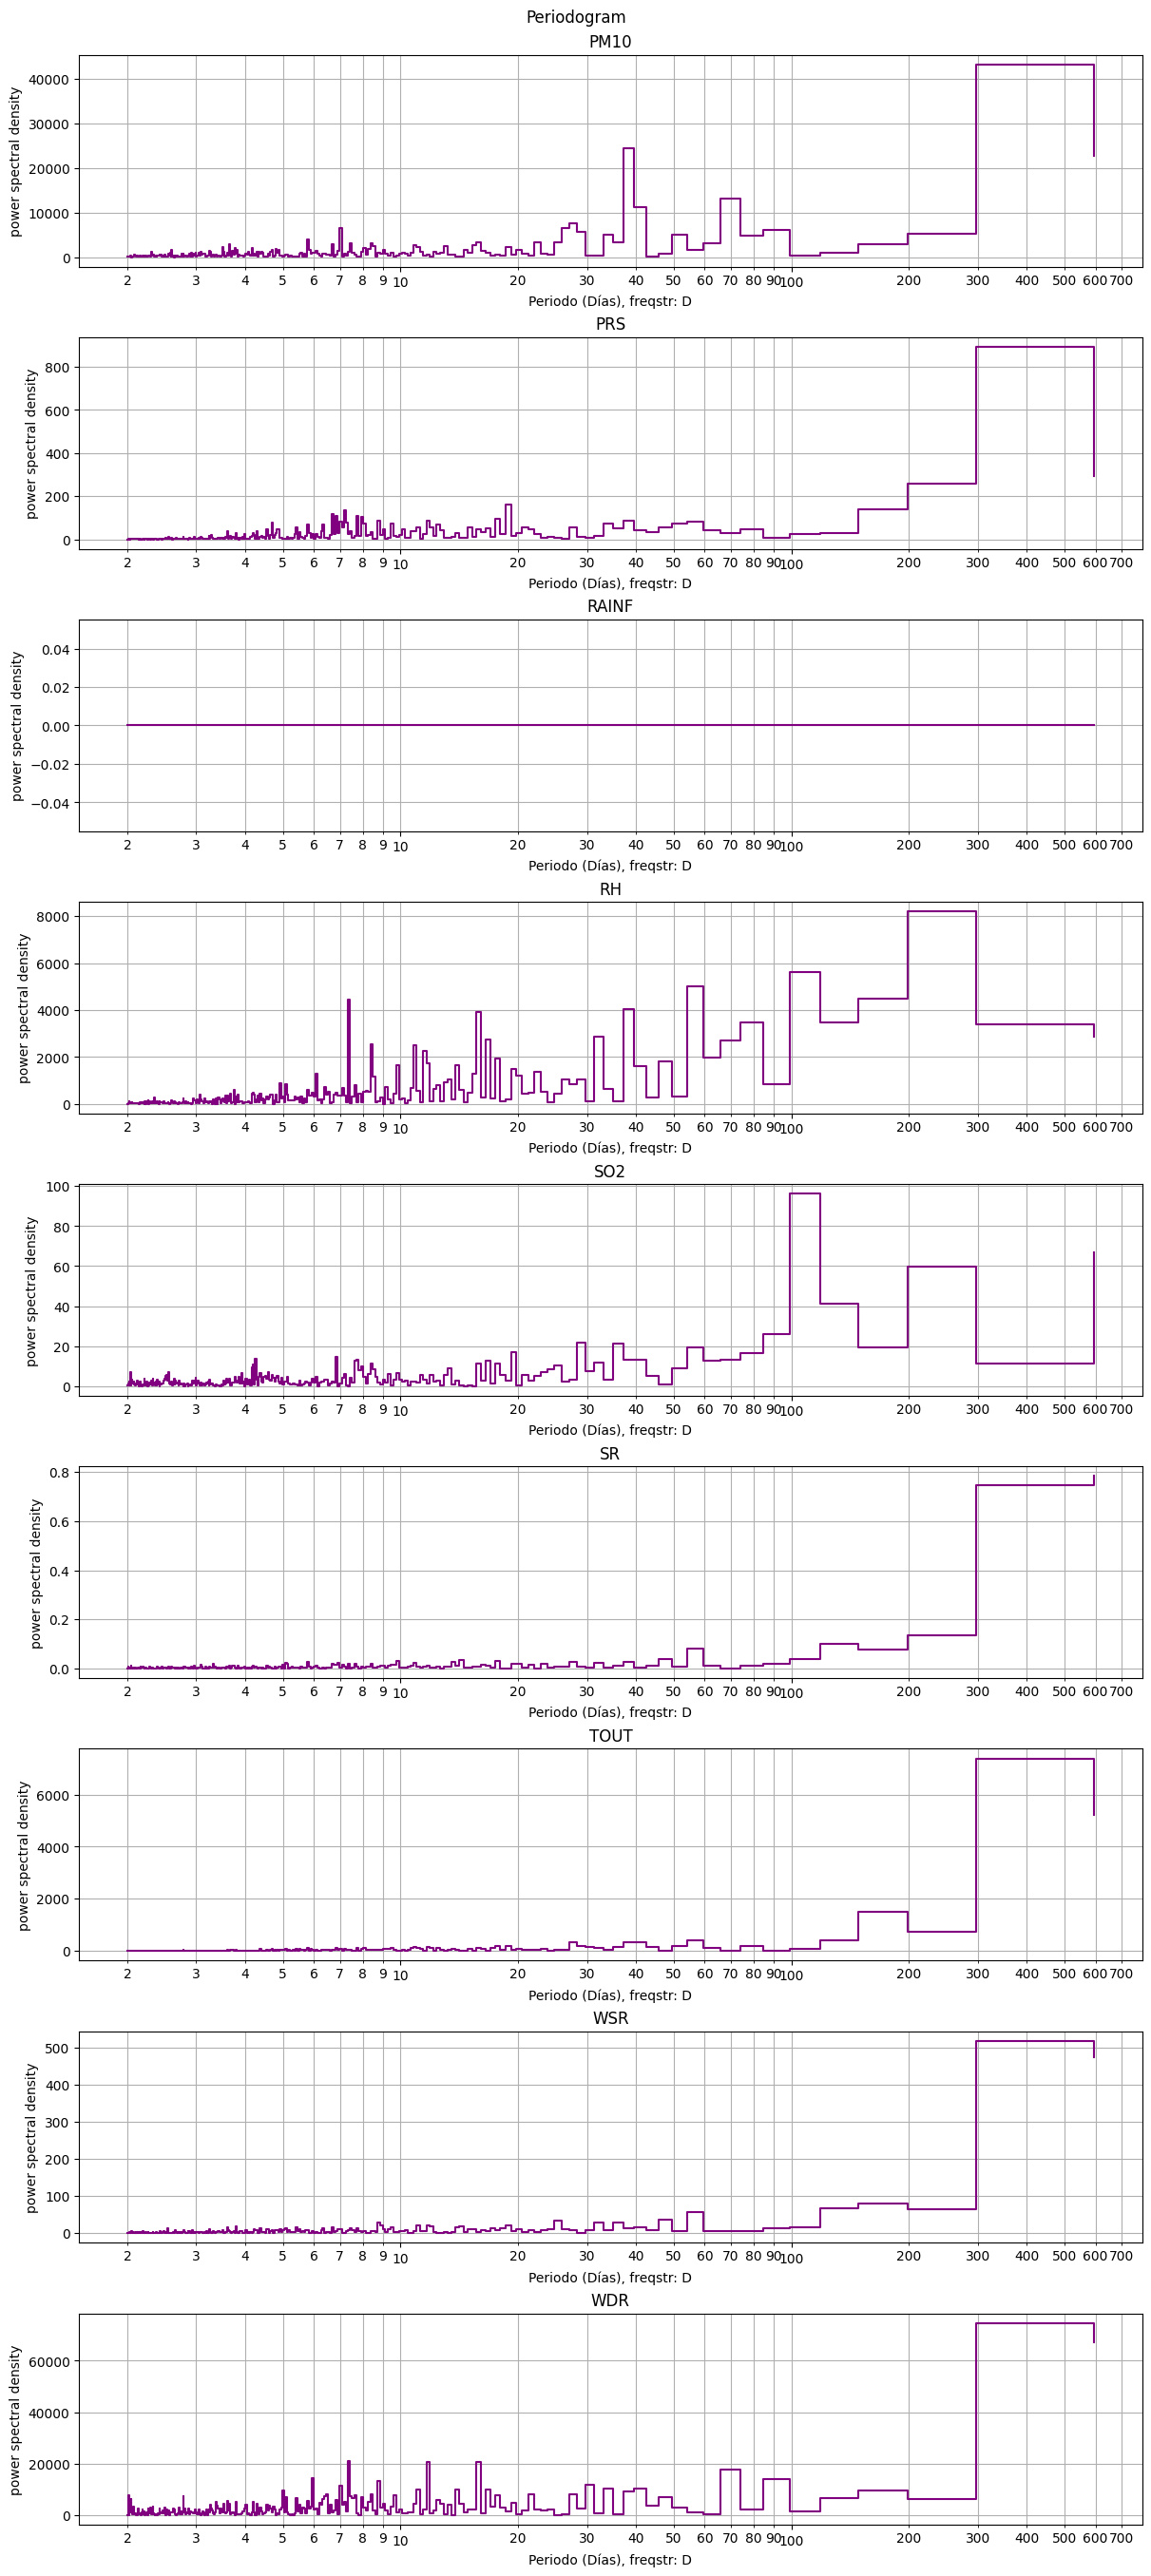

In [62]:
list_periods_spectra = Periodograma(Monterrey_PM10)

In [65]:
Top_10_Periodogram(Monterrey_PM10, list_periods_spectra)


Top 10 para la variable 'PM10':


,top_periods,top_spectra
0,297.000000,43089.661431
1,37.125000,24372.635193
2,594.000000,22712.081778
3,66.000000,13149.515759
4,39.600000,11205.950944
5,27.000000,7517.806027
6,25.826087,6490.400153
7,6.988235,6411.128381
8,84.857143,6016.710748
9,28.285714,5679.708602



Top 10 para la variable 'PRS':


,top_periods,top_spectra
0,297.000000,891.868636
1,594.000000,294.837016
2,198.000000,258.557680
3,18.562500,161.661907
4,148.500000,138.609471
5,7.156627,133.240904
6,6.674157,118.216569
7,6.827586,107.535937
8,7.714286,106.749947
9,7.920000,102.829385



Top 10 para la variable 'RAINF':


,top_periods,top_spectra
0,inf,0.0
1,2.000000,0.0
2,2.006757,0.0
3,2.013559,0.0
4,2.020408,0.0
5,2.027304,0.0
6,2.034247,0.0
7,2.041237,0.0
8,2.048276,0.0
9,2.055363,0.0



Top 10 para la variable 'RH':


,top_periods,top_spectra
0,198.000000,8196.033696
1,99.000000,5628.588856
2,54.000000,5009.111012
3,148.500000,4494.548183
4,7.333333,4457.792929
5,37.125000,4050.108316
6,15.631579,3928.149573
7,74.250000,3470.093540
8,118.800000,3458.576045
9,297.000000,3401.157314



Top 10 para la variable 'SO2':


,top_periods,top_spectra
0,99.000000,96.126998
1,594.000000,66.699628
2,198.000000,59.817142
3,118.800000,41.217408
4,84.857143,25.907210
5,28.285714,21.591300
6,34.941176,21.118327
7,54.000000,19.476020
8,148.500000,19.200087
9,19.161290,17.242854



Top 10 para la variable 'SR':


,top_periods,top_spectra
0,594.000000,0.783758
1,297.000000,0.745808
2,198.000000,0.135233
3,118.800000,0.102052
4,54.000000,0.079895
5,148.500000,0.076676
6,99.000000,0.039606
7,45.692308,0.038328
8,14.142857,0.033107
9,9.737705,0.029937



Top 10 para la variable 'TOUT':


,top_periods,top_spectra
0,297.000,7388.377020
1,594.000,5210.103291
2,148.500,1497.374925
3,198.000,729.033825
4,54.000,390.963147
5,118.800,384.184378
6,37.125,342.220294
7,27.000,341.203083
8,39.600,324.478709
9,49.500,195.635693



Top 10 para la variable 'WSR':


,top_periods,top_spectra
0,297.000000,519.182781
1,594.000000,474.966809
2,148.500000,80.126807
3,118.800000,65.822979
4,198.000000,65.092097
5,54.000000,56.482029
6,45.692308,36.241037
7,24.750000,32.286304
8,34.941176,29.376385
9,31.263158,29.353817



Top 10 para la variable 'WDR':


,top_periods,top_spectra
0,297.000000,74665.314990
1,594.000000,67184.255887
2,7.333333,20898.462197
3,11.647059,20764.629651
4,15.631579,20670.246327
5,66.000000,17813.474838
6,5.940000,14307.338053
7,84.857143,13958.303200
8,8.735294,13363.649912
9,29.700000,11966.758326


## SO2

## CO

In [ ]:
Monterrey_CO = Monterrey[["CO", "PRS", "RAINF", "RH", "SO2", "SR", "TOUT", "WSR", "WDR"]]

## NOX

In [ ]:
Monterrey_NOX = Monterrey[["NOX", "PRS", "RAINF", "RH", "SO2", "SR", "TOUT", "WSR", "WDR"]]

## COV

In [ ]:
Monterrey_COV = Monterrey[["COV", "PRS", "RAINF", "RH", "SO2", "SR", "TOUT", "WSR", "WDR"]]

KeyError: "['COV'] not in index"

## NH3